In [5]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [6]:
class LineWorld:
    def __init__(self, nb_cells=10, start_cell=1, good_end_cell=9, bad_end_cell=0):
        self.done = None
        self.current_state = start_cell  # État actuel
        self.end_good_state = good_end_cell  # État final
        self.end_bad_state = bad_end_cell
        self.reward = 0.0
        self.num_states = nb_cells  # Nombre total d'états
        self.states = [i for i in range(nb_cells)]
        self.actions = [0, 1]
        self.num_actions = 2  # Nombre total d'actions possibles
        self.line_world = ["_"] * (self.num_states - 1)
        self.line_world.insert(self.current_state, "X")

    def reset(self):
        self.reward = 0.0
        self.done = False
        self.current_state = np.random.randint(1, 8)

    def state_description(self):
        return np.array([self.current_state / (self.num_states - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def step(self, action):
        # Si l'action est 1, on avance à droite
        if (action == 1) and (self.current_state != self.end_good_state) and (self.current_state != self.end_bad_state):
            self.current_state += 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'action est 0, on avance à gauche
        elif (action == 0) and (self.current_state != self.end_good_state) and (
                self.current_state != self.end_bad_state):
            self.current_state -= 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'on atteint l'état final, la partie est terminée
        if self.current_state == self.end_good_state:
            self.reward = 1  # Récompense de 1 pour atteindre l'état final
            # print(self.line_world)
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -1
            # print(self.line_world)
            self.done = True
        return self.current_state, self.reward, self.done

In [7]:
def build_compile_model(env):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(env.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [11]:
def ddqn(env, max_iter=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(env)
    target_network = build_compile_model(env)
    nb_steps = 0
    first_episode = True
    
    cumumated_reward = 0
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    batch_size = 32
    memory = deque(maxlen=2000)
    
    for iteretion in range(max_iter):
        print("Iteration : ", iteretion)
        current_state = env.current_state
        if env.done:
            reward_per_episode.append(env.reward)
            step_by_episode.append(step)
            env.reset()
            step = 0
            cumumated_reward = 0
        
        
        actions = env.actions
        current_state = env.current_state
        q_values = q_network.predict(np.array([current_state]))[0]
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            a= np.argmax(q_values)

        old_reward = env.reward
        new_state, reward, done = env.step(a)
        memory.append((old_reward, a, reward, new_state, done))
            
        if done:
                q_values[a] = reward
        else:
            t = target_network.predict(np.array([new_state]))[0]
            q_values[a] = reward + gamma * np.amax(t)
        q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
            
        cumumated_reward += reward
        step += 1

        if done:
            target_network.set_weights(q_network.get_weights())
                
    return reward_per_episode, step_by_episode

Iteration :  0
1/1 [==============================] - 0s 122ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
Iteration :  1
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 120ms/step
Iteration :  2
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  3
1/1 [==============================] - 0s 51ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 45ms/step
Iteration :  4
1/1 [==============================] - 0s 45ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  5
1/1 [==============================] - 0s 40ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  6
1/1 [==========

1/1 [==============================] - 0s 47ms/step
Iteration :  51
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  52
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  53
1/1 [==============================] - 0s 42ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 45ms/step
Iteration :  54
1/1 [==============================] - 0s 45ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  55
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 47ms/step
Iteration :  56
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [=====================

1/1 [==============================] - 0s 45ms/step
Iteration :  101
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 36ms/step
Iteration :  102
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  103
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  104
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 56ms/step
Iteration :  105
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 47ms/step
Iteration :  106
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  152
1/1 [==============================] - 0s 93ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 49ms/step
Iteration :  153
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  154
1/1 [==============================] - 0s 57ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 194ms/step
Iteration :  155
1/1 [==============================] - 0s 65ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 60ms/step
Iteration :  156
1/1 [==============================] - 0s 257ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================

1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 36ms/step
Iteration :  201
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 50ms/step
Iteration :  202
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  203
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  204
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 66ms/step
Iteration :  205
1/1 [==============================] - 0s 52ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  206
1/1 [===============

1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 37ms/step
Iteration :  250
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  251
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 38ms/step
Iteration :  252
1/1 [==============================] - 0s 56ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  253
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 59ms/step
Iteration :  254
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 36ms/step
Iteration :  255
1/1 [===============

1/1 [==============================] - 0s 36ms/step
Iteration :  298
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  299
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  300
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  301
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 56ms/step
Iteration :  302
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  303
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 43ms/step
Iteration :  348
1/1 [==============================] - 0s 55ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  349
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  350
1/1 [==============================] - 0s 59ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  351
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  352
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 54ms/step
Iteration :  353
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [===============

1/1 [==============================] - 0s 47ms/step
Iteration :  398
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 39ms/step
Iteration :  399
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  400
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 50ms/step
Iteration :  401
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  402
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  403
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 45ms/step
Iteration :  447
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 45ms/step
Iteration :  448
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  449
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  450
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  451
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 57ms/step
Iteration :  452
1/1 [===============

1/1 [==============================] - 0s 43ms/step
Iteration :  496
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  497
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  498
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 39ms/step
Iteration :  499
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  500
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  501
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [===============

1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 49ms/step
Iteration :  545
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 53ms/step
Iteration :  546
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  547
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 51ms/step
Iteration :  548
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 47ms/step
Iteration :  549
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 50ms/step
Iteration :  550
1/1 [===============

1/1 [==============================] - 0s 38ms/step
Iteration :  594
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  595
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  596
1/1 [==============================] - 0s 52ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 46ms/step
Iteration :  597
1/1 [==============================] - 0s 54ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  598
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 45ms/step
Iteration :  599
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 52ms/step
Iteration :  600
1/1

1/1 [==============================] - 0s 37ms/step
Iteration :  644
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 37ms/step
Iteration :  645
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  646
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 46ms/step
Iteration :  647
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  648
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 38ms/step
Iteration :  649
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 39ms/step
Iteration :  693
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  694
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 52ms/step
Iteration :  695
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 61ms/step
Iteration :  696
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 37ms/step
Iteration :  697
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  698
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 40ms/step
Iteration :  741
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  742
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 51ms/step
Iteration :  743
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  744
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  745
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  746
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 57ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  790
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 52ms/step
Iteration :  791
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 39ms/step
Iteration :  792
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 50ms/step
Iteration :  793
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 41ms/step
Iteration :  794
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] 

1/1 [==============================] - 0s 45ms/step
Iteration :  839
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 52ms/step
Iteration :  840
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  841
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 35ms/step
Iteration :  842
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  843
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 37ms/step
Iteration :  844
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_'

1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 36ms/step
Iteration :  889
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 42ms/step
Iteration :  890
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 39ms/step
Iteration :  891
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  892
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  893
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 37ms/step
Iteration :  938
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 48ms/step
Iteration :  939
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 47ms/step
Iteration :  940
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  941
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 47ms/step
Iteration :  942
1/1 [==============================] - 0s 67ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  943
1/1 [===============

1/1 [==============================] - 0s 123ms/step
Iteration :  986
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 63ms/step
Iteration :  987
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 43ms/step
Iteration :  988
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
Iteration :  989
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 40ms/step
Iteration :  990
1/1 [==============================] - 0s 54ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 44ms/step
Iteration :  991
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============

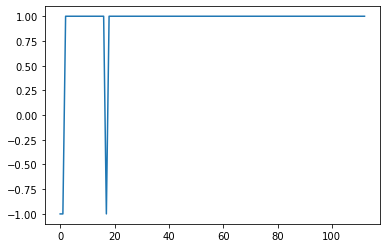

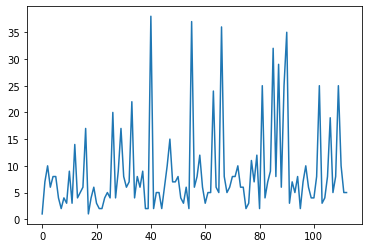

In [12]:
world = LineWorld()
#For 1000
scores, steps = ddqn(world, max_iter = 1000)
plt.plot(scores)
plt.show()
plt.plot(steps)
plt.show()

In [ ]:
#For 10000
scores, steps = ddqn(world, max_iter = 10000)
plt.plot(scores)
plt.show()
plt.plot(steps)
plt.show()